# Tutorial 3: Handling Multidimensional datasets

#### Suhas Somnath
8/8/2017

This set of tutorials will serve as examples for developing end-to-end workflows for and using pycroscopy. 

__In this example, we will learn how to slice multidimensional datasets.__

## Introduction

In pycroscopy, all position dimensions of a dataset are collapsed into the first dimension and all other (spectroscopic) dimensions are collapsed to the second dimension to form a two dimensional matrix. The ancillary matricies, namely the spectroscopic indices and values matrix as well as the position indicies and values matrices will be essential for reshaping the data back to its original N dimensional form and for slicing multidimensional datasets

In [1]:
# downloading packages:
# !pip install -U wget numpy h5py matplotlib ipywidgets pycroscopy

# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals

# In case some of these packages are not installed, install them
#!pip install -U os wget numpy h5py matplotlib pycroscopy

# The package for accessing files in directories, etc.:
import os
import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# basic interactive widgets:
from ipywidgets import interact

# Finally import pycroscopy for certain scientific analysis:
import pycroscopy as px

# set up notebook to show plots within the notebook
% matplotlib inline

## Load the dataset

For this example, we will be working with a Band Excitation Polarization Switching (BEPS) First Order Reversal Curve (FORC) dataset acquired from advanced atomic force microscopes. In the much simpler Band Excitation (BE) imaging datasets, a single spectra is acquired at each location in a two dimensional grid of spatial locations. Thus, BE imaging datasets have two position dimensions (X, Y) and one spectroscopic dimension (frequency - against which the spectra is recorded). The BEPS-FORC dataset used in this example has a spectra for each combination of three other paramaters (DC offset, Field, bias waveform type {FORC}). Thus, this dataset has three new spectral dimensions in addition to the spectra itself. Hence, this dataet becomes a 2+4 = 6 dimensional dataset

In [ ]:
# download the raw data file from Github:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/pycroscopy/master/data/FORC_BEPS.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path)

In [2]:
h5_path = px.io_utils.uiGetFile('*.h5')

In [3]:
# Open the file in read-only mode
h5_file = h5py.File(h5_path, mode='r')

print('Datasets and datagroups within the file:\n------------------------------------')
px.hdf_utils.print_tree(h5_file)

Datasets and datagroups within the file:
------------------------------------
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Bin_FFT
Measurement_000/Channel_000/Bin_Frequencies
Measurement_000/Channel_000/Bin_Indices
Measurement_000/Channel_000/Bin_Step
Measurement_000/Channel_000/Bin_Wfm_Type
Measurement_000/Channel_000/Excitation_Waveform
Measurement_000/Channel_000/Noise_Floor
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Indices
Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000
Measurement_000/Channel_000/Spatially_Averaged_Plot_Group_000/Bin_Frequencies
Measurement_000/Channel_00

In [4]:
h5_meas_grp = h5_file['Measurement_000']
h5_main = h5_meas_grp['Channel_000/Raw_Data']
print('\nThe main dataset:\n------------------------------------')
print(h5_main)


The main dataset:
------------------------------------
<HDF5 dataset "Raw_Data": shape (25, 22272), type "<c8">


The main dataset clearly does not provide the multidimensional information about the data that will be necessary to slice the data. For that we need the ancillary datasets that support this main dataset

In [5]:
# pycroscopy has a convenient function to access datasets linked to a given dataset:
h5_spec_ind = px.hdf_utils.getAuxData(h5_main, 'Spectroscopic_Indices')[0]
h5_spec_val = px.hdf_utils.getAuxData(h5_main, 'Spectroscopic_Values')[0]
h5_pos_ind = px.hdf_utils.getAuxData(h5_main, 'Position_Indices')[0]
h5_pos_val = px.hdf_utils.getAuxData(h5_main, 'Position_Values')[0]

### Understanding the ancillary datasets:

The position datasets are shaped as [spatial points, dimension] while the spectroscopic datasets are shaped as [dimension, spectral points]. Clearly the first axis of the position dataset and the second axis of the spectroscopic datasets match the correponding sizes of the main dataset.

Again, the sum of the position and spectroscopic dimensions results in the 6 dimensions originally described above.

In [6]:
print('Main Datasets of shape:', h5_main.shape)
print('Position Datasets of shape:', h5_pos_ind.shape)
print('Spectroscopic Datasets of shape:', h5_spec_ind.shape)
print('Number of dimensions = ' + str(h5_pos_ind.shape[1]) + ' + ' + 
      str(h5_spec_ind.shape[0]) + ' = ' + 
      str(h5_pos_ind.shape[1] + h5_spec_ind.shape[0]))

Main Datasets of shape: (25, 22272)
Position Datasets of shape: (25, 2)
Spectroscopic Datasets of shape: (4, 22272)
Number of dimensions = 2 + 4 = 6


Essentially, there is a unique combination of position and spectroscopic parameters for each cell in the two dimensionam main dataset. The interactive widgets below illustrate this point. The first slider represents the position dimension while the second represents the spectroscopic dimension. Each position index can be decoded to a set of X and Y indices and values while each spectroscopic index can be decoded into a set of frequency, dc offset, field, and forc parameters

In [7]:
spec_labels = px.hdf_utils.get_formatted_labels(h5_spec_ind)
pos_labels = px.hdf_utils.get_formatted_labels(h5_pos_ind)

def index_ancillary(pos_index, spec_index):
    for dim_ind, dim_name in enumerate(pos_labels):
        print(dim_name,':',h5_pos_ind[pos_index, dim_ind])
    for dim_ind, dim_name in enumerate(spec_labels):
        print(dim_name,':',h5_spec_ind[dim_ind, spec_index])
interact(index_ancillary, pos_index=(0,h5_main.shape[0]-1, 1), spec_index=(0,h5_main.shape[1]-1, 1));

## Visualizing the ancillary datasets

The plots below show how the position and spectrocopic dimensions vary. Due to the high dimensionality of the spectroscopic dimensions, the variation of each dimension has been plotted separately.

#### How we interpret these plots:

__Positions__: For each Y index, the X index ramps up from 0 to 4 and repeats. Essentially, this means that for a given Y index, there were multiple measurments (different values of X)

__Spectroscopic__: The plot for `FORC` shows that the next fastest dimension - `DC offset` was varied 6 times. Correspondingly, the plot for `DC offset` plot shows that this dimension ramps up from 0 to a little less than 40 for each `FORC` index. This trend is the same for the faster varying dimensions - `Frequency` and `Field`. 

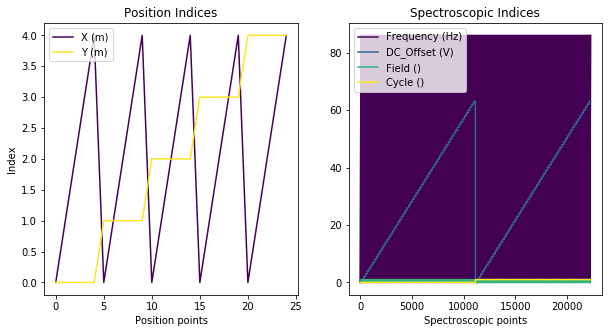

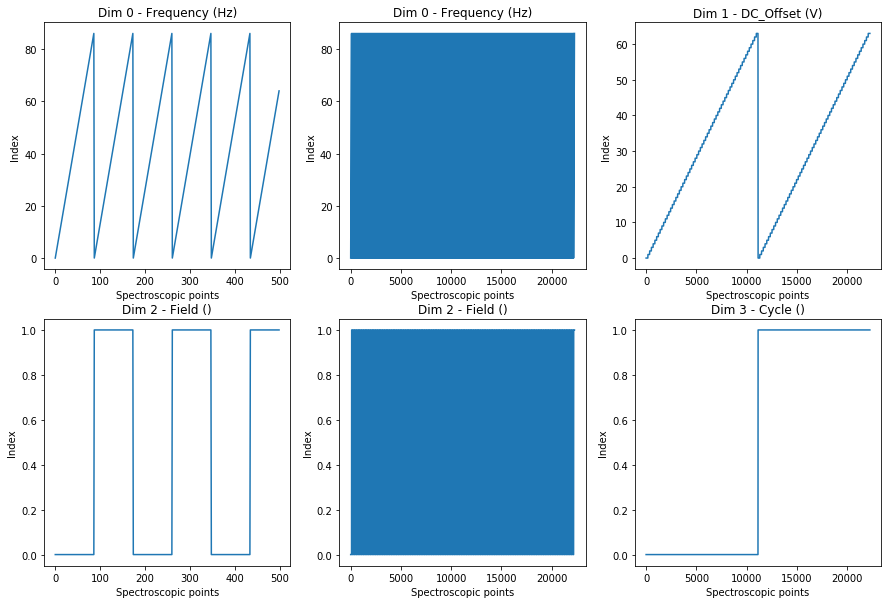

In [8]:
fig_1, axes = plt.subplots(ncols=2, figsize=(10,5))
px.plot_utils.plot_line_family(axes[0], np.arange(h5_pos_ind.shape[0]), h5_pos_ind[()].T, 
                               line_names=pos_labels)
axes[0].set_xlabel('Position points')
axes[0].set_ylabel('Index')
axes[0].set_title('Position Indices')
axes[0].legend()
px.plot_utils.plot_line_family(axes[1], np.arange(h5_spec_ind.shape[1]), h5_spec_ind, 
                               line_names=spec_labels)
axes[1].set_xlabel('Spectroscopic points')
axes[1].set_title('Spectroscopic Indices')
axes[1].legend()

fig_2, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
for dim_ind, axis, dim_label, dim_array in zip([0,2], [axes.flat[0], axes.flat[3]], 
                                               [spec_labels[0], spec_labels[2]], 
                                               [h5_spec_ind[0,:500], h5_spec_ind[2,:500]]):
    axis.plot(np.arange(dim_array.size), dim_array)
    axis.set_xlabel('Spectroscopic points')
    axis.set_ylabel('Index')
    axis.set_title('Dim ' + str(dim_ind) + ' - ' + dim_label)
    
rhs_axes = [axes.flat[ind] for ind in [1,2,4,5]]
for dim_ind, axis, dim_label, dim_array in zip(range(h5_spec_ind.shape[0]), rhs_axes, spec_labels, h5_spec_ind):
    axis.plot(np.arange(dim_array.size), dim_array)
    axis.set_xlabel('Spectroscopic points')
    axis.set_ylabel('Index')
    axis.set_title('Dim ' + str(dim_ind) + ' - ' + dim_label)

In [9]:
# A similar version of this function is available in pycroscopy.io.hdf_utils.get_formatted_labels
def describe_dimensions(h5_aux):
    for name, unit in zip(px.hdf_utils.get_attr(h5_aux, 'labels'),
                            px.hdf_utils.get_attr(h5_aux, 'units')):
        print(name, '[', unit, ']')

print('Position dimension names and units:')
describe_dimensions(h5_pos_ind)

print('\nSpectrocopic dimension names and units:')
describe_dimensions(h5_spec_ind)   

Position dimension names and units:
X [ m ]
Y [ m ]

Spectrocopic dimension names and units:
Frequency [ Hz ]
DC_Offset [ V ]
Field [  ]
Cycle [  ]


## Now lets find the size in each dimension
For now lets assume that data is sampled at each position and at each spectral step
In other words lets assume that data was not sampled over a random subset of points within a grid of points

In [10]:
# The function below has been implemented as pycroscopy.io.hdf_utils.get_dimensionality
def get_dim_sizes(ind_dset, is_position=False):
    # ind_dset here is expected to be of the shape [dimension, points] like the spectroscopic indices
    if is_position:
        # Position dimensions will be turned from [points, dimension] to [dimension, points]
        ind_dset = np.transpose(ind_dset[()])
        
    dim_size = []
    for col in ind_dset:
        # For each dimension array, we will find the number of unique elements in it
        dim_size.append(len(np.unique(col)))
    return dim_size

pos_dim_sizes = get_dim_sizes(h5_pos_ind, is_position=True)
spec_dim_sizes = get_dim_sizes(h5_spec_ind)

print('Positions:',pos_dim_sizes, '\nSpectroscopic:', spec_dim_sizes)

print('\nPosition dimensions and their sizes:')
for label, dim_size in zip(pos_labels, pos_dim_sizes):
    print(label, ':', dim_size)
    
print('\nSpectroscopic dimensions and their sizes:')
for label, dim_size in zip(spec_labels, spec_dim_sizes):
    print(label, ':', dim_size)

Positions: [5, 5] 
Spectroscopic: [87, 64, 2, 2]

Position dimensions and their sizes:
X (m) : 5
Y (m) : 5

Spectroscopic dimensions and their sizes:
Frequency (Hz) : 87
DC_Offset (V) : 64
Field () : 2
Cycle () : 2


## Slicing the Main dataset

Let's assume that we are interested in visualizing the spectrograms at the first field of the second cycle at position - row:3 and column 2. There are two ways of accessing the data:
1. The easier method - reshape the data to N dimensions and slice the dataset
    * This approach, while trivial, may not be suitable for large datasets which may or may not fit in memory
2. The harder method - find the spectroscopic and position indices of interest and slice the 2D dataset

### Approach 1 - N-dimensional form
We will use convenient pycroscopy function that safely reshapes the data to its N dimensional form with a single line. 

In [13]:
import h5py
from warnings import warn
import numpy as np
from pycroscopy.io.microdata import MicroDataset
from pycroscopy.io.hdf_utils import get_sort_order, get_dimensionality, get_attr

def reshape_to_Ndims(h5_main, h5_pos=None, h5_spec=None, get_labels=False, verbose=False):
    """
    Reshape the input 2D matrix to be N-dimensions based on the
    position and spectroscopic datasets.

    Parameters
    ----------
    h5_main : HDF5 Dataset
        2D data to be reshaped
    h5_pos : HDF5 Dataset, optional
        Position indices corresponding to rows in `h5_main`
    h5_spec : HDF5 Dataset, optional
        Spectroscopic indices corresponding to columns in `h5_main`
    get_labels : bool
        Should the labels be returned.  Default False

    Returns
    -------
    ds_Nd : N-D numpy array
        N dimensional numpy array arranged as [positions slowest to fastest, spectroscopic slowest to fastest]
    success : boolean or string
        True if full reshape was successful

        "Positions" if it was only possible to reshape by
        the position dimensions

        False if no reshape was possible
    ds_labels : list of str
        List of the labels of each dimension of `ds_Nd`

    Notes
    -----
    If either `h5_pos` or `h5_spec` are not provided, the function will first
    attempt to find them as attributes of `h5_main`.  If that fails, it will
    generate dummy values for them.

    """

    if h5_pos is None:
        """
        Get the Position datasets from the references if possible
        """
        if isinstance(h5_main, h5py.Dataset):
            try:
                h5_pos = h5_main.file[h5_main.attrs['Position_Indices']]
                ds_pos = h5_pos[()]
            except KeyError:
                print('No position datasets found as attributes of {}'.format(h5_main.name))
                if len(h5_main.shape) > 1:
                    ds_pos = np.arange(h5_main.shape[0], dtype=np.uint8).reshape(-1, 1)
                else:
                    ds_pos = np.array(0, dtype=np.uint8).reshape(-1, 1)
            except:
                raise
        else:
            ds_pos = np.arange(h5_main.shape[0], dtype=np.uint32).reshape(-1, 1)
    elif isinstance(h5_pos, h5py.Dataset):
        """
    Position Indices dataset was provided
        """
        ds_pos = h5_pos[()]
    elif isinstance(h5_pos, np.ndarray):
        ds_pos = h5_pos
    else:
        raise TypeError('Position Indices must be either h5py.Dataset or None')

    ##################################################

    if h5_spec is None:
        """
        Get the Spectroscopic datasets from the references if possible
        """
        if isinstance(h5_main, h5py.Dataset):
            try:
                h5_spec = h5_main.file[h5_main.attrs['Spectroscopic_Indices']]
                ds_spec = h5_spec[()]
            except KeyError:
                print('No spectroscopic datasets found as attributes of {}'.format(h5_main.name))
                if len(h5_main.shape) > 1:
                    ds_spec = np.arange(h5_main.shape[1], dtype=np.uint8).reshape([1, -1])
                else:
                    ds_spec = np.array(0, dtype=np.uint8).reshape([1, 1])
            except:
                raise
        else:
            ds_spec = np.arange(h5_main.shape[1], dtype=np.uint8).reshape([1, -1])

    elif isinstance(h5_spec, h5py.Dataset):
        """
    Spectroscopic Indices dataset was provided
        """
        ds_spec = h5_spec[()]

    elif isinstance(h5_spec, np.ndarray):
        ds_spec = h5_spec
    else:
        raise TypeError('Spectroscopic Indices must be either h5py.Dataset or None')

    '''
    Sort the indices from fastest to slowest
    '''
    pos_sort = get_sort_order(np.transpose(ds_pos))
    spec_sort = get_sort_order(ds_spec)
    
    if verbose:
        print('Position dimensions:', get_attr(h5_pos, 'labels'))
        print('Position sort order:', pos_sort)
        print('Spectroscopic Dimensions:', get_attr(h5_spec_ind, 'labels'))
        print('Spectroscopic sort order:', spec_sort)

    '''
    Get the size of each dimension in the sorted order
    '''
    pos_dims = get_dimensionality(np.transpose(ds_pos), pos_sort)
    spec_dims = get_dimensionality(ds_spec, spec_sort)
    
    if verbose:
        print('\nPosition dimensions (sort applied):', get_attr(h5_pos, 'labels')[pos_sort])
        print('Position dimensionality (sort applied):', pos_dims)
        print('Spectroscopic dimensions (sort applied):', get_attr(h5_spec_ind, 'labels')[spec_sort])
        print('Spectroscopic dimensionality (sort applied):', spec_dims)
        
        all_labels = np.hstack((get_attr(h5_pos, 'labels')[pos_sort][::-1], 
                                get_attr(h5_spec_ind, 'labels')[spec_sort][::-1]))


    ds_main = h5_main[()]

    """
    Now we reshape the dataset based on those dimensions
    numpy reshapes correctly when the dimensions are arranged from slowest to fastest. 
    Since the sort orders we have are from fastest to slowest, we need to reverse the orders
    for both the position and spectroscopic dimensions
    """
    try:
        ds_Nd = np.reshape(ds_main, pos_dims[::-1] + spec_dims[::-1])
    except ValueError:
        warn('Could not reshape dataset to full N-dimensional form.  Attempting reshape based on position only.')
        try:
            ds_Nd = np.reshape(ds_main, pos_dims[-1])
            return ds_Nd, 'Positions'
        except ValueError:
            warn('Reshape by position only also failed.  Will keep dataset in 2d form.')
            return ds_main, False
        except:
            raise
    except:
        raise
        
    if verbose:
        print('\nAfter first reshape, labels are', all_labels)
        print('Data shape is', ds_Nd.shape)

    """
    Now we reverse the ordering of the axes such that they from fast to slow again
    for both the position and spectroscopic dimensions
    """    
    reverse_axes = np.append(np.arange(pos_sort.size-1,-1,-1),
                             np.arange(spec_sort.size-1,-1,-1) + len(pos_dims))
    
    if verbose:
        print('\nAxes will permuted in this order:', reverse_axes)
        print('New labels ordering:', all_labels[reverse_axes])

    ds_Nd2 = np.transpose(ds_Nd, reverse_axes)
    
    if verbose:
        print('Dataset now of shape:', ds_Nd2.shape)

    if get_labels:
        '''
        Get the labels in the proper order
        '''
        if isinstance(h5_pos, h5py.Dataset):
            pos_labs = get_attr(h5_pos, 'labels')
        else:
            pos_labs = np.array(['' for _ in pos_dims])
        if isinstance(h5_spec, h5py.Dataset):
            spec_labs = get_attr(h5_spec, 'labels')[spec_sort]
        else:
            spec_labs = np.array(['' for _ in spec_dims])

        ds_labels = np.hstack([pos_labs, spec_labs])

        results = (ds_Nd2, True, ds_labels)
    else:
        results = (ds_Nd2, True)

    return results

In [14]:
ds_nd, success, labels = reshape_to_Ndims(h5_main, get_labels=True)
print('Shape of the N-dimensional dataset:', ds_nd.shape)
print(labels)

Shape of the N-dimensional dataset: (5, 5, 87, 2, 64, 2)
['X' 'Y' 'Frequency' 'Field' 'DC_Offset' 'Cycle']


Now that we have the data in its original N dimensional form, we can easily slice the dataset:

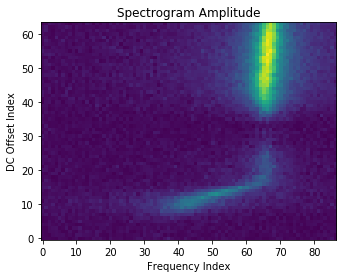

In [15]:
spectrogram = ds_nd[3,2, :, 1, :, 0]
# Now the spectrogram is of order (frequency x DC_Offset).
spectrogram = spectrogram.T
# Now the spectrogram is of order (DC_Offset x frequency)
fig, axis = plt. subplots()
axis.imshow(np.abs(spectrogram), origin='lower')
axis.set_xlabel('Frequency Index')
axis.set_ylabel('DC Offset Index')
axis.set_title('Spectrogram Amplitude');

### Approach 2 - slicing the 2D matrix

first field of the second cycle at position - row:3 and column 2

In [119]:
# Get only the spectroscopic dimension names:
spec_dim_names = px.hdf_utils.get_attr(h5_spec_ind,'labels')

# Find the row in the spectroscopic indices that corresponds to the dimensions we want to slice:
cycle_row_ind = np.where(spec_dim_names == 'Cycle')[0][0]
# Find the row correspoding to field in the same way:
field_row_ind = np.where(spec_dim_names == 'Field')[0][0]

# Find all the spectral indices corresponding to the second cycle:
desired_cycle = h5_spec_ind[cycle_row_ind] == 1

# Do the same to find the spectral indicies for the first field:
desired_field = h5_spec_ind[field_row_ind] == 0

# Now find the indices where the cycle = 1 and the field = 0 using a logical AND statement:
spec_slice = np.logical_and(desired_cycle, desired_field)

# We will use the same approach to find the position indices 
# corresponding to the row index of 3 and colum index of 2:
pos_dim_names = px.hdf_utils.get_attr(h5_pos_ind,'labels')

x_col_ind = np.where(pos_dim_names == 'X')[0][0]
y_col_ind = np.where(pos_dim_names == 'Y')[0][0]

desired_x = h5_pos_ind[:, x_col_ind] == 2
desired_y = h5_pos_ind[:, y_col_ind] == 3

pos_slice = np.logical_and(desired_x, desired_y)

# Now use the spectroscopic and position slice arrays to slice the 2D dataset:
spectrogram2 = h5_main[pos_slice, :][:, spec_slice]

# Note that the sliced data is effectively one dimensional since the spectroscopic
# dimensions were flattened to a single dimension
print(spectrogram2.shape)

(1, 5568)


In [120]:
# Reshape this dataset to the 2D spectrogram that we desire:

# For this we need to find the size of the data in the DC_offset and Frequency dimensions:
dc_dim_ind = np.where(spec_dim_names == 'DC_Offset')[0][0]
# Find the row correspoding to field in the same way:
freq_dim_ind = np.where(spec_dim_names == 'Frequency')[0][0]

dc_dim_size = spec_dim_sizes[dc_dim_ind]
freq_dim_size = spec_dim_sizes[freq_dim_ind]
print(dc_dim_size, freq_dim_size)

# The order of the dimensions is also important:
spec_sort_order = px.hdf_utils.get_sort_order(h5_spec_ind)
print(spec_sort_order)

if spec_sort_order[dc_dim_ind] > spec_sort_order[freq_dim_ind]:
    spectrogram_shape = (dc_dim_size, freq_dim_size)
else:
    spectrogram_shape = (freq_dim_size, dc_dim_size)

spectrogram2 = np.reshape(np.squeeze(spectrogram2), spectrogram_shape)

print(spectrogram2.shape)

64 87
[0 2 1 3]
(64, 87)


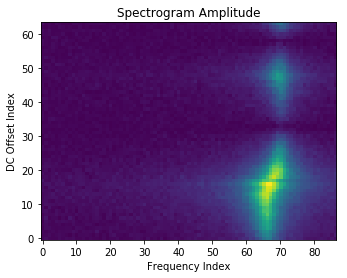

In [121]:
# Now the spectrogram is of order (DC_Offset x frequency)
fig, axis = plt. subplots()
axis.imshow(np.abs(spectrogram2), origin='lower')
axis.set_xlabel('Frequency Index')
axis.set_ylabel('DC Offset Index')
axis.set_title('Spectrogram Amplitude');

In [31]:
spec_dim_names = px.hdf_utils.get_attr(h5_spec_ind,'labels')

# Find the row in the spectroscopic indices that corresponds to the dimensions we want to slice:
np.where(spec_dim_names == 'Cycle')[0][0]

3